# Evaluate our own model

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix
#from fastai.imports import *
#from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
#from fastai.dataset import *
#from fastai.sgdr import *

from fastai.plots import *
import numpy as np
PATH = "../../datasets/boeing_vs_airbus/"
arch = resnext50

def get_file_list(directory):
    return [val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk(directory)] for val in sublist]


def get_prediction(image, learn):   
    trn_tfms, val_tfms = tfms_from_model(arch,300) # get transformations
    im = val_tfms(open_image(image))
    learn.precompute=False # We'll pass in a raw image, not activations
    preds = learn.predict_array(im[None])
    return preds

def compute_stats(cm, classes):
    plot_confusion_matrix(cm, classes)
    # precission = VP / (VP + FP)
    precision = cm[0][0]/(cm[0][1]+cm[0][0]);
    print("Precision : ", precision)
    # recall =  = VP / (VP + FN)
    recall = cm[0][0]/(cm[1][0]+cm[0][0]);
    print("Recall : ", recall)
    F1 = 2 * ((precision*recall)/(precision + recall))
    print("F1 : ", F1)
    F2 = 5 * ((precision*recall)/(4*precision + recall))
    print("F2 : ", F2)

def check_prediction(classe, classes, learn):
    error = 0
    files = get_file_list(f'{PATH}valid/' + classes[classe])
    print("Input images number : ", len(files))
    csv = ""
    for image in files:
        preds = get_prediction(image, learn)
        pred = np.argmax(preds)
        if classe != pred:
            print("PREDICTION ERROR for ", image, "with score", preds) # [pred]*100
            error += 1
            img=mpimg.imread(image)
            imgplot = plt.imshow(img)
            plt.show()
            csv_string = image + ";" + str(classe) + ";" + classes[classe] + ";" + str(preds) + "=>" + str(pred) + ";0\n"
        else:
            csv_string = image + ";" + str(classe) + ";" + classes[classe] + ";" + str(preds) + "=>" + str(pred) + ";1\n"
        #print(csv_string)
        csv += csv_string
        #print(classes[classe], " preds : ", str(preds), " argmax:", str(pred))
        #break
#     f = open("resnext50-" + classes[classe] + "-result.csv", "w")
#     f.write(csv)
#     f.close()
    print(error, "errors on", len(files), "predictions for", classe)
    return error, len(files)

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:

tfms = tfms_from_model(arch, 300)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
#learn.load("resnext50_141_300_acc98.06_weights") # 3 + 4 errors
#learn.load("acc97.74_resnext50_1269_300_weights") # 4 + 5 errors
learn.load("resnext506_bestmodel") # 2 + 2
#learn.load("resnext509_bestmodel") # 2 + 4
#learn.load("resnext504_bestmodel") # 3 + 3
#learn.load("resnext508_bestmodel") # 4 + 1 
print("Model chargé")

Model chargé


Input images number :  154
PREDICTION ERROR for  ../../datasets/boeing_vs_airbus/valid/A380/81.2018-06-05t094602z_1_lynxnpee540tp_rtroptp_3_tarmac-aerosave-recycling-plane.jpg with score [[-0.98298 -0.46871]]


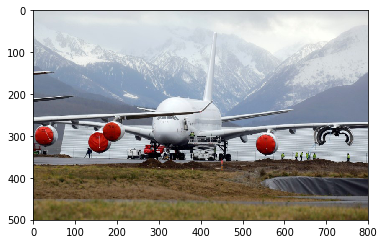

PREDICTION ERROR for  ../../datasets/boeing_vs_airbus/valid/A380/137.aerial-view-airbus-a380-for-emirates-before-finishing-on-the-tarmac-faeban.jpg with score [[-1.05989 -0.4254 ]]


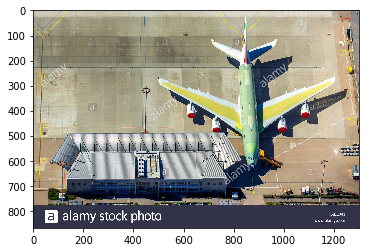

2 errors on 154 predictions for 0
Input images number :  155
PREDICTION ERROR for  ../../datasets/boeing_vs_airbus/valid/B747/43.image.jpg with score [[-0.35316 -1.21221]]


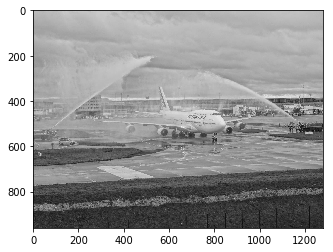

PREDICTION ERROR for  ../../datasets/boeing_vs_airbus/valid/B747/544.soaring-hawk-spur.jpg with score [[-0.02425 -3.73151]]


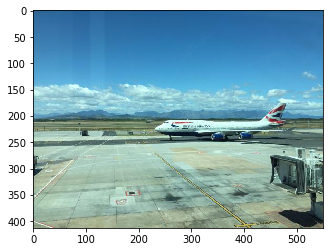

2 errors on 155 predictions for 1


In [15]:
classes = ["A380", "B747"]
errors_B747, numbers_of_B747 = check_prediction(0, classes, learn)
errors_A380, numbers_of_A380 = check_prediction(1, classes, learn)
cm = np.array([[numbers_of_B747-errors_B747, errors_B747],[errors_A380, numbers_of_A380-errors_A380]])

It's interresting to note that best models do not make the same errors.

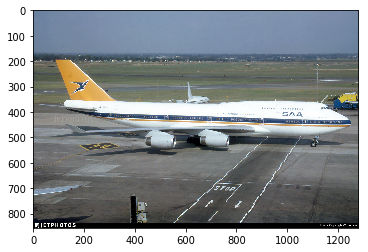

array([[-10.14295,  -0.00004]], dtype=float32)

'B747'

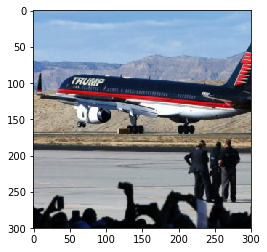

array([[-5.29132, -0.00505]], dtype=float32)

'B747'

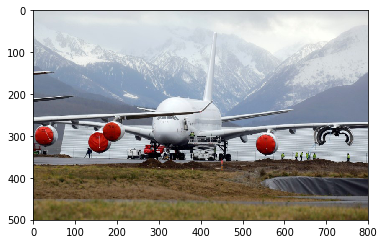

array([[-0.98298, -0.46871]], dtype=float32)

'B747'

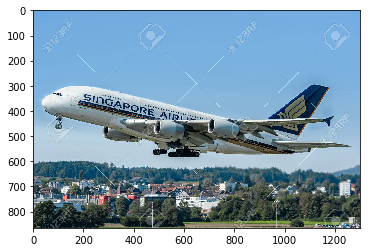

array([[-0.00008, -9.37854]], dtype=float32)

'A380'

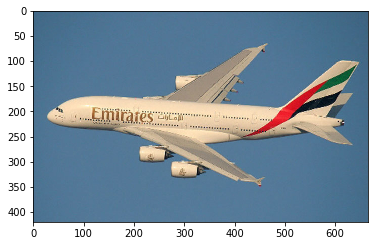

array([[-0.00219, -6.12377]], dtype=float32)

'A380'

In [16]:
for image in [
    "../../datasets/boeing_vs_airbus/valid/B747/103.40503_1513368429.jpg",
    "../../datasets/boeing_vs_airbus/valid/B747/506.gty-trmp-plane-tarmac-mem-161206_12x5_1600-300x300.jpg",
    "../../datasets/boeing_vs_airbus/valid/A380/81.2018-06-05t094602z_1_lynxnpee540tp_rtroptp_3_tarmac-aerosave-recycling-plane.jpg",
    "../../datasets/boeing_vs_airbus/valid/A380/349.82850622-partir-de-l-ac3a9roport-de-zurich-ce-grand-airbus-a380.jpg",
    "../../datasets/boeing_vs_airbus/valid/A380/83.6972079-10661793.jpg"
             ]:
    imgplot = plt.imshow(mpimg.imread(image))
    plt.show()
    log_predict = get_prediction(image, learn)
    log_predict
    preds = np.argmax(log_predict)
    classes[preds]

[[152   2]
 [  2 153]]
Precision :  0.987012987012987
Recall :  0.987012987012987
F1 :  0.987012987012987
F2 :  0.9870129870129869


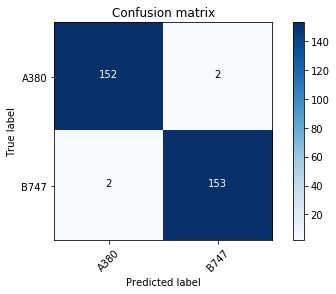

In [17]:
compute_stats(cm, classes)